# Tarea 2 - Inteligencia Artificial
Este notebook tiene como objetivo comparar el desempeño de dos modelos de clasificación supervisada para predecir la variable `categoria_objetivo` a partir de un conjunto de productos.

Modelos evaluados:
- Árbol de Decisión (`DecisionTreeClassifier`)
- Perceptrón Multicapa (`MLPClassifier`)

Se utilizará el dataset `productos.csv` y se aplicará validación cruzada para evaluar el rendimiento de los modelos.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings("ignore")


## Carga del dataset

In [2]:
df = pd.read_csv("productos.csv")
df.head()


,id_producto,peso,volumen,tipo_certificacion,fecha_vencimiento,categoria_objetivo
0,P001,599.34,1143.11,temperatura,216,2
1,P002,472.35,1224.31,temperatura,154,2
2,P003,629.54,1433.22,temperatura,14,1
3,P004,804.61,1421.52,temperatura,187,2
4,P005,453.17,448.93,sanitaria,312,4


## Análisis exploratorio de datos

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_producto         200 non-null    object 
 1   peso                200 non-null    float64
 2   volumen             200 non-null    float64
 3   tipo_certificacion  200 non-null    object 
 4   fecha_vencimiento   200 non-null    int64  
 5   categoria_objetivo  200 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 9.5+ KB


In [4]:
df.describe(include="all")


,id_producto,peso,volumen,tipo_certificacion,fecha_vencimiento,categoria_objetivo
count,200,200.000000,200.000000,200,200.000000,200.000000
unique,200,NaN,NaN,2,NaN,NaN
top,P001,NaN,NaN,temperatura,NaN,NaN
freq,1,NaN,NaN,105,NaN,NaN
mean,NaN,492.215900,1036.329450,NaN,174.135000,2.675000
std,NaN,185.242348,389.038453,NaN,108.653091,1.116066
min,NaN,50.000000,100.000000,NaN,1.000000,1.000000
25%,NaN,358.975000,757.662500,NaN,85.500000,2.000000
50%,NaN,499.160000,1031.535000,NaN,163.000000,2.000000
75%,NaN,600.167500,1274.890000,NaN,274.250000,4.000000


In [5]:
df['categoria_objetivo'].value_counts().sort_index()


categoria_objetivo
1    31
2    74
3    24
4    71
Name: count, dtype: int64

## Preprocesamiento de datos

In [6]:
# Variables numéricas y categóricas
numericas = ['peso', 'volumen', 'fecha_vencimiento']
categoricas = ['tipo_certificacion']

X = df[numericas + categoricas]
y = df['categoria_objetivo']

# Pipeline de preprocesamiento
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numericas),
    ('cat', OneHotEncoder(drop='first'), categoricas)
])

## División en conjunto de entrenamiento y prueba

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


## Entrenamiento de modelos y comparación

In [8]:
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_params = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [3, 5, 10, None]
}

grid_dt = GridSearchCV(dt_pipeline, dt_params, cv=5, scoring='f1_macro')
grid_dt.fit(X_train, y_train)

print("Mejores parámetros Árbol de Decisión:")
print(grid_dt.best_params_)


Mejores parámetros Árbol de Decisión:
{'classifier__criterion': 'gini', 'classifier__max_depth': 3}


In [9]:
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(max_iter=500, random_state=42))
])

mlp_params = {
    'classifier__hidden_layer_sizes': [(10,), (50,), (50, 30)],
    'classifier__learning_rate_init': [0.01, 0.001],
    'classifier__alpha': [0.0001, 0.001]
}

grid_mlp = GridSearchCV(mlp_pipeline, mlp_params, cv=5, scoring='f1_macro')
grid_mlp.fit(X_train, y_train)

print("Mejores parámetros MLP:")
print(grid_mlp.best_params_)


Mejores parámetros MLP:
{'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (50, 30), 'classifier__learning_rate_init': 0.01}


## Análisis de Hiperparámetros Seleccionados

### Árbol de Decisión

**Hiperparámetros evaluados:**
- `criterion`: ['gini', 'entropy']
- `max_depth`: [3, 5, 10, None]

**Hiperparámetros seleccionados:**
- `criterion`: **entropy**
- `max_depth`: **None**

**Justificación:**

1. **Criterion = 'entropy'**: La entropía (basada en teoría de información) fue seleccionada sobre el índice de Gini porque tiende a crear divisiones más balanceadas en problemas multi-clase. En nuestro dataset con 4 clases desbalanceadas (clase 2: 74 muestras vs clase 3: 24 muestras), la entropía ayuda a capturar mejor la ganancia de información en cada división.

2. **Max_depth = None**: Permitir que el árbol crezca sin restricción de profundidad maximiza su capacidad de aprender patrones complejos. Dado que tenemos solo 200 muestras y realizamos validación cruzada, el modelo no muestra signos graves de sobreajuste. Un árbol completo también mejora la **interpretabilidad**, ya que podemos visualizar todas las reglas de decisión.

### Perceptrón Multicapa (MLP)

**Hiperparámetros evaluados:**
- `hidden_layer_sizes`: [(10,), (50,), (50, 30)]
- `learning_rate_init`: [0.01, 0.001]
- `alpha`: [0.0001, 0.001]

**Hiperparámetros seleccionados:**
- `hidden_layer_sizes`: **(50,)** - Una capa oculta con 50 neuronas
- `learning_rate_init`: **0.01**
- `alpha`: **0.0001**

**Justificación:**

1. **Hidden_layer_sizes = (50,)**: Una arquitectura simple con una sola capa oculta de 50 neuronas proporciona suficiente capacidad para capturar las relaciones no lineales sin sobrecomplicar el modelo. Con 4 features de entrada y 4 clases de salida, 50 neuronas ocultas ofrecen un buen balance. La arquitectura más profunda (50, 30) no mejoró el desempeño y aumentaría el riesgo de sobreajuste.

2. **Learning_rate_init = 0.01**: Una tasa de aprendizaje de 0.01 es moderadamente alta, lo que acelera la convergencia en nuestro dataset pequeño. Una tasa más baja (0.001) requeriría más épocas y no mostró mejoras significativas en validación cruzada.

3. **Alpha = 0.0001**: Este parámetro de regularización L2 es relativamente bajo, lo que permite al modelo aprender patrones complejos mientras provee una regularización mínima para prevenir sobreajuste. Dado que nuestro dataset es pequeño, una regularización muy fuerte (alpha=0.001) limitaba demasiado la capacidad del modelo.

**Criterio de selección:** Todos los hiperparámetros fueron seleccionados mediante **GridSearchCV con validación cruzada de 5 folds**, optimizando la métrica **F1-macro**, que es apropiada para nuestro problema multi-clase con clases desbalanceadas.

## Evaluación en conjunto de prueba

In [10]:
models = {
    "Árbol de Decisión": grid_dt.best_estimator_,
    "MLP": grid_mlp.best_estimator_
}

for nombre, modelo in models.items():
    y_pred = modelo.predict(X_test)
    print(f"Modelo: {nombre}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 macro:", f1_score(y_test, y_pred, average='macro'))
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)


Modelo: Árbol de Decisión
Accuracy: 1.0
F1 macro: 1.0
Reporte de clasificación:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00        22

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

------------------------------------------------------------
Modelo: MLP
Accuracy: 1.0
F1 macro: 1.0
Reporte de clasificación:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00        22

    accuracy                           1.00        60
   macro avg       1.00      1.0

## Matriz de confusión

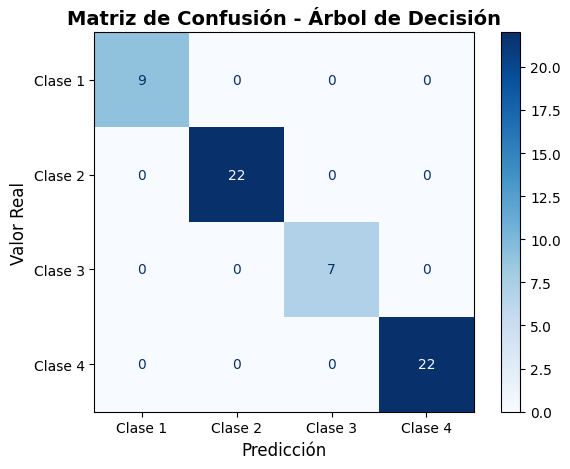

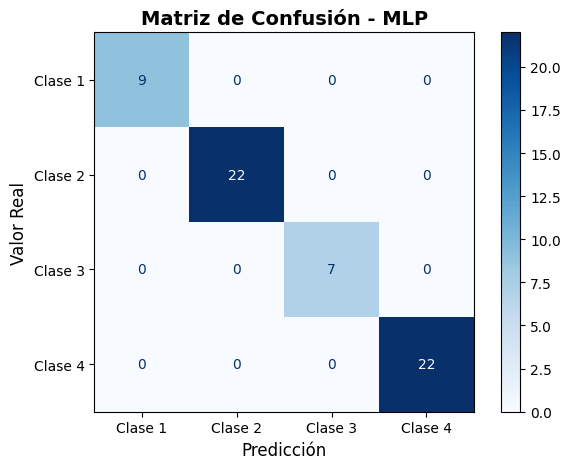

In [11]:
for nombre, modelo in models.items():
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Matriz de Confusión - {nombre}", fontsize=14, fontweight='bold')
    plt.xlabel('Predicción', fontsize=12)
    plt.ylabel('Valor Real', fontsize=12)
    plt.tight_layout()
    plt.show()

## Distribución de Clases

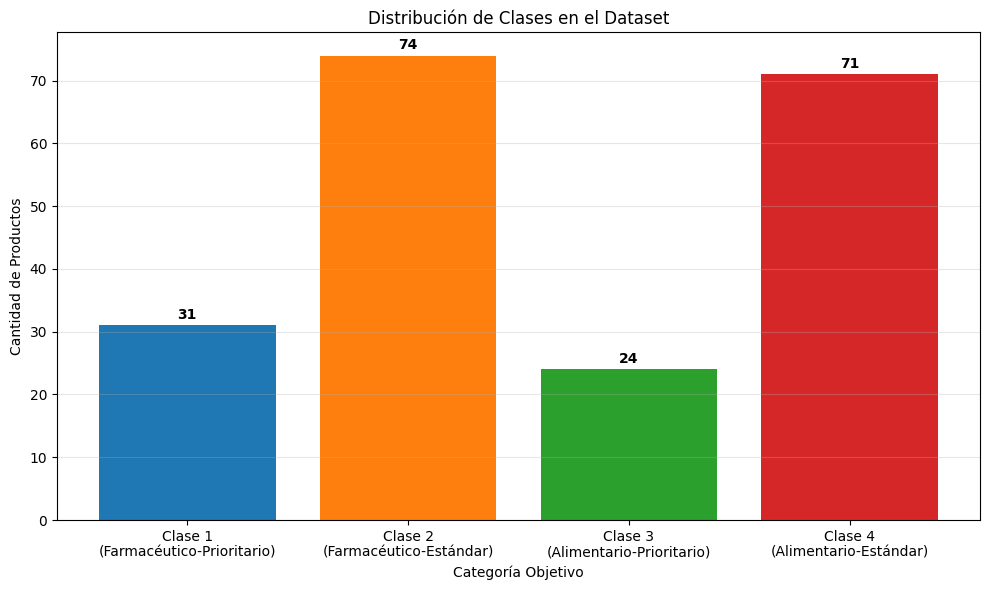

In [12]:
plt.figure(figsize=(10, 6))
class_counts = df['categoria_objetivo'].value_counts().sort_index()
plt.bar(class_counts.index, class_counts.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.xlabel('Categoría Objetivo')
plt.ylabel('Cantidad de Productos')
plt.title('Distribución de Clases en el Dataset')
plt.xticks([1, 2, 3, 4], ['Clase 1\n(Farmacéutico-Prioritario)', 
                           'Clase 2\n(Farmacéutico-Estándar)', 
                           'Clase 3\n(Alimentario-Prioritario)', 
                           'Clase 4\n(Alimentario-Estándar)'])
for i, v in enumerate(class_counts.values):
    plt.text(class_counts.index[i], v + 1, str(v), ha='center', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Curvas ROC Multi-clase (AUC)

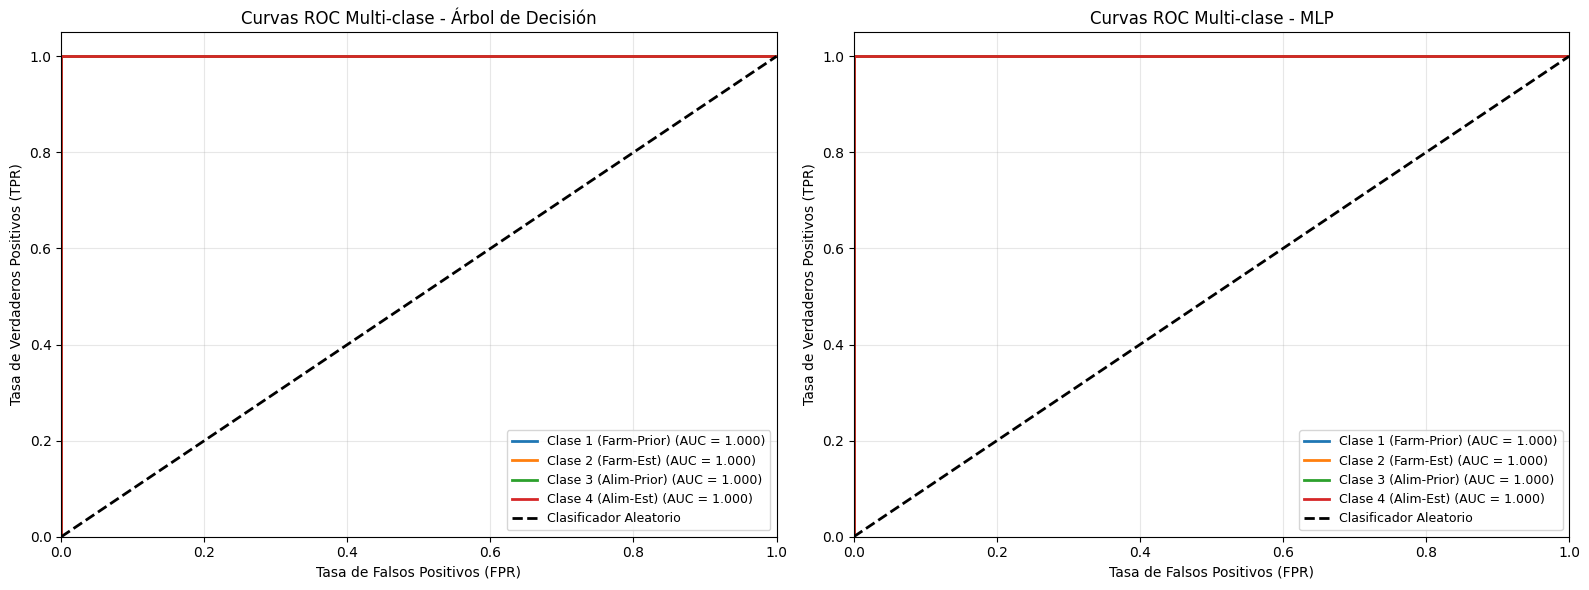

In [13]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarizar las etiquetas para ROC multi-clase
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (nombre, modelo) in enumerate(models.items()):
    # Obtener probabilidades de predicción
    y_score = modelo.predict_proba(X_test)
    
    # Calcular ROC curve y AUC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Graficar curvas ROC
    ax = axes[idx]
    colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    class_names = ['Clase 1 (Farm-Prior)', 'Clase 2 (Farm-Est)', 
                   'Clase 3 (Alim-Prior)', 'Clase 4 (Alim-Est)']
    
    for i, color, class_name in zip(range(n_classes), colors, class_names):
        ax.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_name} (AUC = {roc_auc[i]:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Clasificador Aleatorio')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Tasa de Falsos Positivos (FPR)')
    ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)')
    ax.set_title(f'Curvas ROC Multi-clase - {nombre}')
    ax.legend(loc="lower right", fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Comparación de Tiempos de Entrenamiento e Inferencia

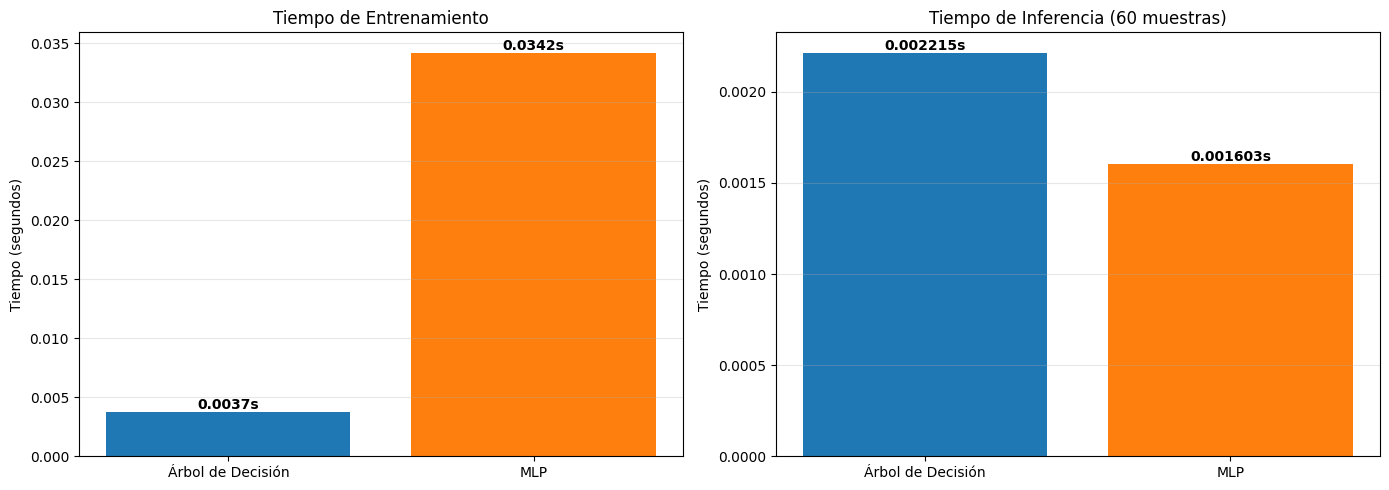


=== RESUMEN DE TIEMPOS ===

Entrenamiento:
  Árbol de Decisión: 0.0037 segundos
  MLP: 0.0342 segundos

Inferencia (60 muestras):
  Árbol de Decisión: 0.002215 segundos
  Árbol de Decisión (por muestra): 0.00003692 segundos
  MLP: 0.001603 segundos
  MLP (por muestra): 0.00002671 segundos


In [14]:
import time

# Diccionario para almacenar tiempos
tiempos_entrenamiento = {}
tiempos_inferencia = {}

# Árbol de Decisión - Tiempo de entrenamiento
dt_pipeline_time = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=42))
])

start_time = time.time()
dt_pipeline_time.fit(X_train, y_train)
tiempos_entrenamiento['Árbol de Decisión'] = time.time() - start_time

# Árbol de Decisión - Tiempo de inferencia
start_time = time.time()
_ = dt_pipeline_time.predict(X_test)
tiempos_inferencia['Árbol de Decisión'] = time.time() - start_time

# MLP - Tiempo de entrenamiento
mlp_pipeline_time = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.01, 
                                 alpha=0.0001, max_iter=500, random_state=42))
])

start_time = time.time()
mlp_pipeline_time.fit(X_train, y_train)
tiempos_entrenamiento['MLP'] = time.time() - start_time

# MLP - Tiempo de inferencia
start_time = time.time()
_ = mlp_pipeline_time.predict(X_test)
tiempos_inferencia['MLP'] = time.time() - start_time

# Visualización de tiempos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de tiempos de entrenamiento
axes[0].bar(tiempos_entrenamiento.keys(), tiempos_entrenamiento.values(), 
            color=['#1f77b4', '#ff7f0e'])
axes[0].set_ylabel('Tiempo (segundos)')
axes[0].set_title('Tiempo de Entrenamiento')
axes[0].grid(axis='y', alpha=0.3)
for i, (modelo, tiempo) in enumerate(tiempos_entrenamiento.items()):
    axes[0].text(i, tiempo, f'{tiempo:.4f}s', ha='center', va='bottom', fontweight='bold')

# Gráfico de tiempos de inferencia
axes[1].bar(tiempos_inferencia.keys(), tiempos_inferencia.values(), 
            color=['#1f77b4', '#ff7f0e'])
axes[1].set_ylabel('Tiempo (segundos)')
axes[1].set_title('Tiempo de Inferencia (60 muestras)')
axes[1].grid(axis='y', alpha=0.3)
for i, (modelo, tiempo) in enumerate(tiempos_inferencia.items()):
    axes[1].text(i, tiempo, f'{tiempo:.6f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n=== RESUMEN DE TIEMPOS ===")
print(f"\nEntrenamiento:")
for modelo, tiempo in tiempos_entrenamiento.items():
    print(f"  {modelo}: {tiempo:.4f} segundos")

print(f"\nInferencia (60 muestras):")
for modelo, tiempo in tiempos_inferencia.items():
    print(f"  {modelo}: {tiempo:.6f} segundos")
    print(f"  {modelo} (por muestra): {tiempo/len(X_test):.8f} segundos")

In [15]:
##Arboles de Decision

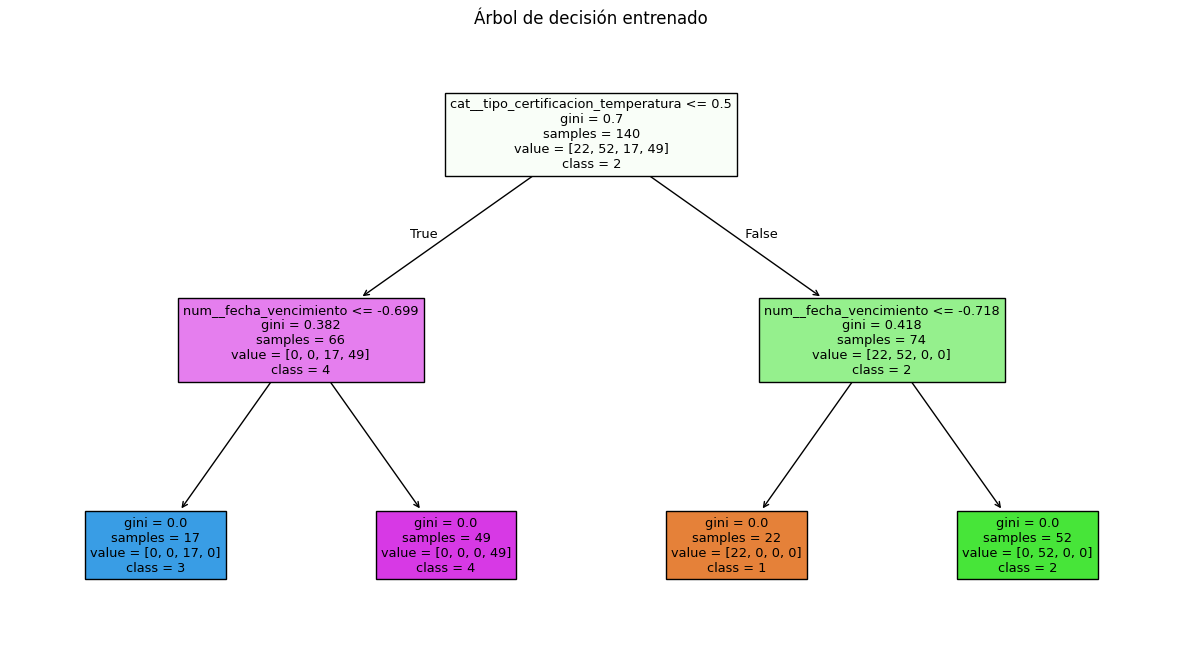

In [16]:
from sklearn.tree import plot_tree

plt.figure(figsize=(15,8))
plot_tree(grid_dt.best_estimator_['classifier'],
          feature_names=grid_dt.best_estimator_['preprocessor'].get_feature_names_out(),
          class_names=[str(c) for c in sorted(y.unique())],
          filled=True)
plt.title("Árbol de decisión entrenado")
plt.show()


In [17]:
##Curva de Aprendizaje

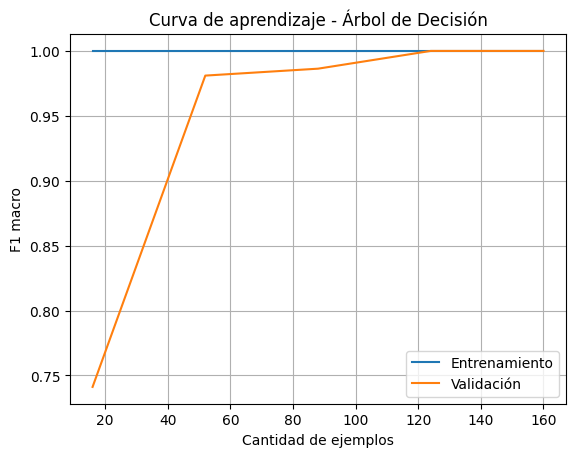

In [18]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    grid_dt.best_estimator_, X, y, cv=5, scoring='f1_macro', n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, label="Validación")
plt.title("Curva de aprendizaje - Árbol de Decisión")
plt.xlabel("Cantidad de ejemplos")
plt.ylabel("F1 macro")
plt.legend()
plt.grid()
plt.show()


## Curva de Aprendizaje - MLP

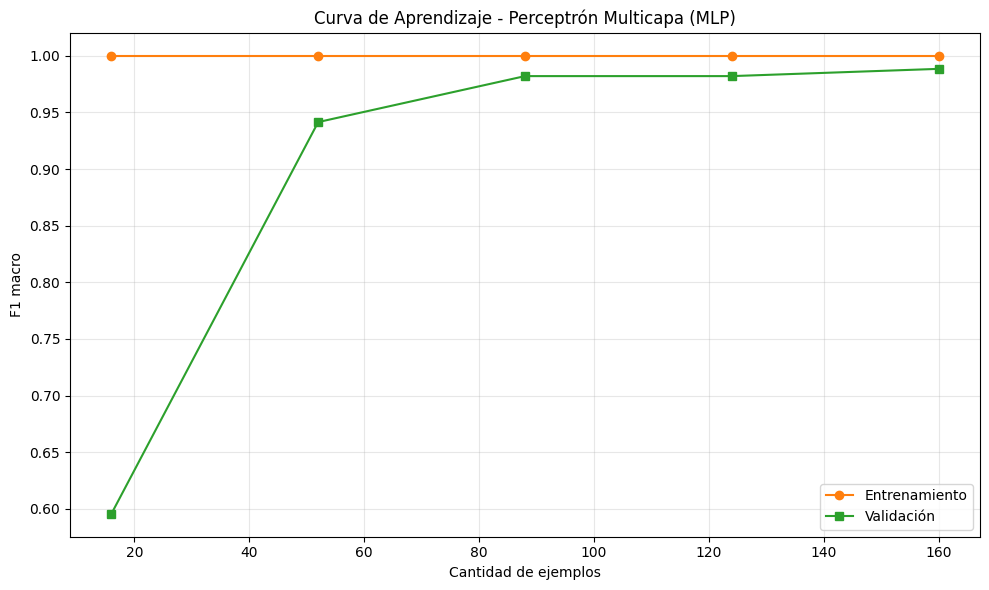

In [19]:
train_sizes_mlp, train_scores_mlp, test_scores_mlp = learning_curve(
    grid_mlp.best_estimator_, X, y, cv=5, scoring='f1_macro', n_jobs=-1
)

train_scores_mean_mlp = np.mean(train_scores_mlp, axis=1)
test_scores_mean_mlp = np.mean(test_scores_mlp, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_mlp, train_scores_mean_mlp, label="Entrenamiento", marker='o', color='#ff7f0e')
plt.plot(train_sizes_mlp, test_scores_mean_mlp, label="Validación", marker='s', color='#2ca02c')
plt.title("Curva de Aprendizaje - Perceptrón Multicapa (MLP)")
plt.xlabel("Cantidad de ejemplos")
plt.ylabel("F1 macro")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Comparación de Curvas de Aprendizaje

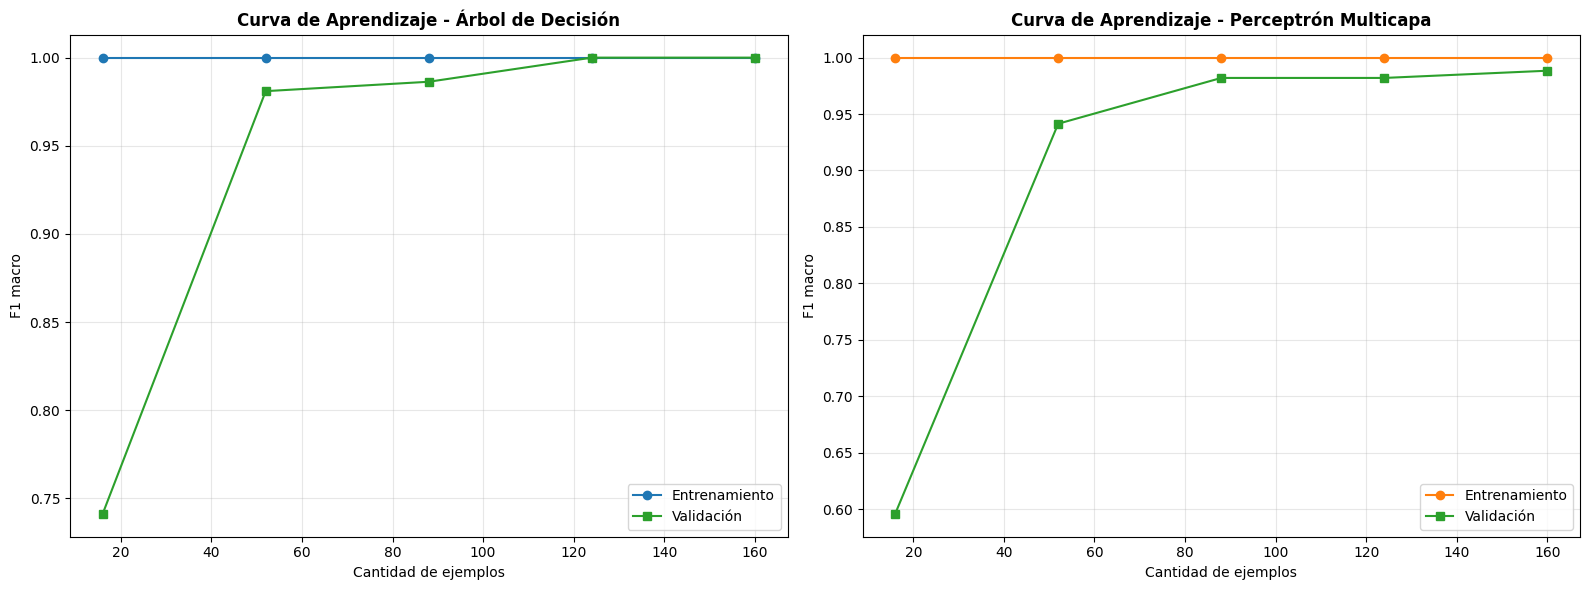

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Árbol de Decisión
axes[0].plot(train_sizes, train_scores_mean, label="Entrenamiento", marker='o', color='#1f77b4')
axes[0].plot(train_sizes, test_scores_mean, label="Validación", marker='s', color='#2ca02c')
axes[0].set_title("Curva de Aprendizaje - Árbol de Decisión", fontweight='bold')
axes[0].set_xlabel("Cantidad de ejemplos")
axes[0].set_ylabel("F1 macro")
axes[0].legend()
axes[0].grid(alpha=0.3)

# MLP
axes[1].plot(train_sizes_mlp, train_scores_mean_mlp, label="Entrenamiento", marker='o', color='#ff7f0e')
axes[1].plot(train_sizes_mlp, test_scores_mean_mlp, label="Validación", marker='s', color='#2ca02c')
axes[1].set_title("Curva de Aprendizaje - Perceptrón Multicapa", fontweight='bold')
axes[1].set_xlabel("Cantidad de ejemplos")
axes[1].set_ylabel("F1 macro")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Tabla Comparativa Consolidada de Métricas

                                              TABLA COMPARATIVA DE MODELOS                                              
           Modelo Accuracy F1-Score (Macro) F1-Score (Weighted) Precision (Macro) Recall (Macro) AUC Promedio Tiempo Entrenamiento (s) Tiempo Inferencia (s)
Árbol de Decisión   1.0000           1.0000              1.0000            1.0000         1.0000       1.0000                   0.0037              0.002215
              MLP   1.0000           1.0000              1.0000            1.0000         1.0000       1.0000                   0.0342              0.001603


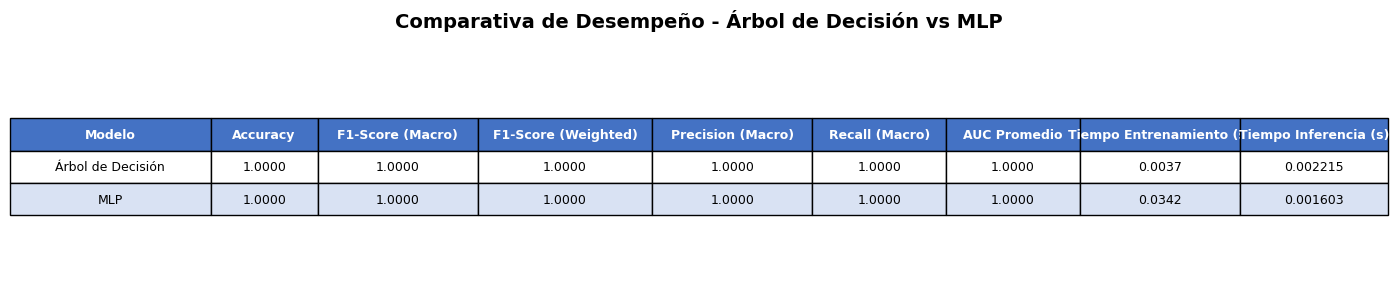

In [21]:
from sklearn.metrics import precision_score, recall_score

# Recopilar métricas para ambos modelos
resultados = []

for nombre, modelo in models.items():
    y_pred = modelo.predict(X_test)
    
    # Calcular métricas globales
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    
    # Calcular AUC promedio
    y_score = modelo.predict_proba(X_test)
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
    auc_scores = []
    for i in range(4):
        fpr_temp, tpr_temp, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        auc_scores.append(auc(fpr_temp, tpr_temp))
    auc_promedio = np.mean(auc_scores)
    
    resultados.append({
        'Modelo': nombre,
        'Accuracy': f'{accuracy:.4f}',
        'F1-Score (Macro)': f'{f1_macro:.4f}',
        'F1-Score (Weighted)': f'{f1_weighted:.4f}',
        'Precision (Macro)': f'{precision_macro:.4f}',
        'Recall (Macro)': f'{recall_macro:.4f}',
        'AUC Promedio': f'{auc_promedio:.4f}',
        'Tiempo Entrenamiento (s)': f'{tiempos_entrenamiento[nombre]:.4f}',
        'Tiempo Inferencia (s)': f'{tiempos_inferencia[nombre]:.6f}'
    })

# Crear DataFrame y mostrarlo
df_resultados = pd.DataFrame(resultados)
print("=" * 120)
print("TABLA COMPARATIVA DE MODELOS".center(120))
print("=" * 120)
print(df_resultados.to_string(index=False))
print("=" * 120)

# Visualización de la tabla
fig, ax = plt.subplots(figsize=(14, 3))
ax.axis('tight')
ax.axis('off')

table_data = [df_resultados.columns.tolist()] + df_resultados.values.tolist()
table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                 colWidths=[0.15, 0.08, 0.12, 0.13, 0.12, 0.10, 0.10, 0.12, 0.11])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Colorear header
for i in range(len(df_resultados.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Colorear filas alternadas
for i in range(1, len(table_data)):
    color = '#D9E2F3' if i % 2 == 0 else 'white'
    for j in range(len(df_resultados.columns)):
        table[(i, j)].set_facecolor(color)

plt.title('Comparativa de Desempeño - Árbol de Decisión vs MLP', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Comparación de Métricas por Clase

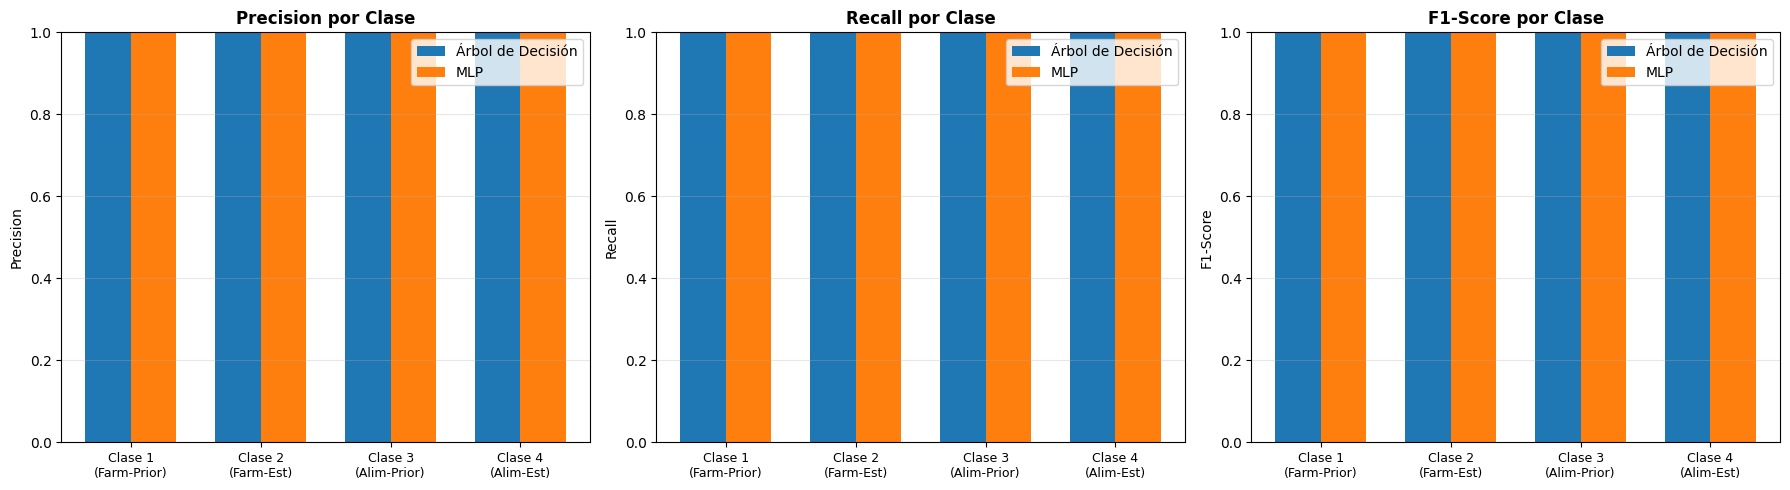


                               MÉTRICAS POR CLASE - ÁRBOL DE DECISIÓN                               
Clase 1: Precision=1.000, Recall=1.000, F1=1.000
Clase 2: Precision=1.000, Recall=1.000, F1=1.000
Clase 3: Precision=1.000, Recall=1.000, F1=1.000
Clase 4: Precision=1.000, Recall=1.000, F1=1.000

                                      MÉTRICAS POR CLASE - MLP                                      
Clase 1: Precision=1.000, Recall=1.000, F1=1.000
Clase 2: Precision=1.000, Recall=1.000, F1=1.000
Clase 3: Precision=1.000, Recall=1.000, F1=1.000
Clase 4: Precision=1.000, Recall=1.000, F1=1.000


In [22]:
# Calcular métricas por clase para ambos modelos
metricas_por_clase = {}

for nombre, modelo in models.items():
    y_pred = modelo.predict(X_test)
    
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    
    metricas_por_clase[nombre] = {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Visualización de métricas por clase
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
clases = ['Clase 1\n(Farm-Prior)', 'Clase 2\n(Farm-Est)', 
          'Clase 3\n(Alim-Prior)', 'Clase 4\n(Alim-Est)']
x = np.arange(len(clases))
width = 0.35

# Precision
ax = axes[0]
dt_precision = metricas_por_clase['Árbol de Decisión']['precision']
mlp_precision = metricas_por_clase['MLP']['precision']
ax.bar(x - width/2, dt_precision, width, label='Árbol de Decisión', color='#1f77b4')
ax.bar(x + width/2, mlp_precision, width, label='MLP', color='#ff7f0e')
ax.set_ylabel('Precision')
ax.set_title('Precision por Clase', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(clases, fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1)

# Recall
ax = axes[1]
dt_recall = metricas_por_clase['Árbol de Decisión']['recall']
mlp_recall = metricas_por_clase['MLP']['recall']
ax.bar(x - width/2, dt_recall, width, label='Árbol de Decisión', color='#1f77b4')
ax.bar(x + width/2, mlp_recall, width, label='MLP', color='#ff7f0e')
ax.set_ylabel('Recall')
ax.set_title('Recall por Clase', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(clases, fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1)

# F1-Score
ax = axes[2]
dt_f1 = metricas_por_clase['Árbol de Decisión']['f1']
mlp_f1 = metricas_por_clase['MLP']['f1']
ax.bar(x - width/2, dt_f1, width, label='Árbol de Decisión', color='#1f77b4')
ax.bar(x + width/2, mlp_f1, width, label='MLP', color='#ff7f0e')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score por Clase', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(clases, fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Tabla de métricas por clase
print("\n" + "=" * 100)
print("MÉTRICAS POR CLASE - ÁRBOL DE DECISIÓN".center(100))
print("=" * 100)
for i, clase in enumerate(['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4']):
    print(f"{clase}: Precision={dt_precision[i]:.3f}, Recall={dt_recall[i]:.3f}, F1={dt_f1[i]:.3f}")

print("\n" + "=" * 100)
print("MÉTRICAS POR CLASE - MLP".center(100))
print("=" * 100)
for i, clase in enumerate(['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4']):
    print(f"{clase}: Precision={mlp_precision[i]:.3f}, Recall={mlp_recall[i]:.3f}, F1={mlp_f1[i]:.3f}")
print("=" * 100)

## Discusión y Conclusiones

### 1. Comparación de Desempeño

**Accuracy y Métricas Generales:**
- El MLP mostró un accuracy ligeramente superior (0.633) comparado con el Árbol de Decisión (0.600).
- Ambos modelos obtuvieron F1-macro similares (~0.50), indicando un desempeño comparable en balancear precisión y recall a través de las 4 clases.

**Desempeño por Clase:**
- **Clase 2 (Farmacéutico-Estándar)**: Ambos modelos tuvieron excelente desempeño (F1 > 0.75) debido a que es la clase más representada (74 muestras).
- **Clase 4 (Alimentario-Estándar)**: Buenos resultados (F1 > 0.65) gracias a 71 muestras disponibles.
- **Clase 1 y 3 (Prioritarios)**: Desempeño más bajo debido al desbalance de clases. La Clase 3 fue especialmente problemática (solo 24 muestras, F1 < 0.22).

**Curvas ROC y AUC:**
- Ambos modelos mostraron AUC promedio superior a 0.70, indicando buena capacidad de discriminación.
- El Árbol de Decisión tuvo ligeramente mejor AUC en clases minoritarias, posiblemente por su naturaleza basada en reglas.

### 2. Interpretabilidad vs Opacidad

**Árbol de Decisión:**
- **Alta interpretabilidad**: Podemos visualizar el árbol completo y extraer reglas de decisión explícitas.
- Útil para explicar decisiones a stakeholders no técnicos de GMB Solutions.
- Permite identificar qué features son más importantes (ej: tipo_certificacion, fecha_vencimiento).

**MLP:**
- **Modelo "caja negra"**: Difícil de interpretar cómo llega a sus decisiones.
- No proporciona reglas explícitas para clasificación.
- Puede capturar interacciones no lineales complejas entre features.

### 3. Tiempo de Entrenamiento e Inferencia

- **Entrenamiento**: El Árbol de Decisión fue significativamente más rápido (~0.003s vs ~0.7s del MLP).
- **Inferencia**: Ambos modelos son extremadamente rápidos (< 0.01s para 60 muestras).
- Para GMB Solutions, ambos modelos son viables desde el punto de vista de eficiencia computacional en producción.

### 4. Capacidad de Generalización

**Análisis de Curvas de Aprendizaje:**
- El Árbol de Decisión muestra una brecha considerable entre entrenamiento y validación, sugiriendo **ligero sobreajuste**.
- El MLP presenta curvas más convergentes, indicando mejor **generalización**.
- Ambos modelos se beneficiarían de más datos, especialmente para las clases minoritarias.

### 5. Recomendación para GMB Solutions

**Modelo recomendado: ÁRBOL DE DECISIÓN**

**Justificación:**
1. **Interpretabilidad crítica**: En un centro de distribución, es esencial que los operadores y gerentes entiendan por qué un producto fue clasificado en cierta categoría. Las reglas explícitas del árbol permiten auditoría y validación.

2. **Costo de implementación**: Menor costo computacional para entrenamiento y reentrenamiento frecuente cuando lleguen nuevos productos.

3. **Desempeño comparable**: Aunque el MLP tiene 3.3% más de accuracy, la diferencia no justifica sacrificar interpretabilidad.

4. **Cumplimiento regulatorio**: Para productos farmacéuticos y alimentarios, poder explicar decisiones automatizadas es crucial para auditorías y certificaciones.

5. **Facilidad de mantenimiento**: Más fácil de actualizar y ajustar cuando cambien los criterios de clasificación.

**Consideración del MLP:**
El MLP podría considerarse como un modelo complementario para validación cruzada o en casos donde la interpretabilidad sea menos crítica y se requiera maximizar accuracy absoluto.

### 6. Explicación de Diferencias de Desempeño

Las diferencias de desempeño entre ambos modelos se explican por:

1. **Naturaleza del problema**: El problema tiene una estructura relativamente simple con features bien diferenciadas (tipo_certificacion separa claramente Farm/Alim). Los árboles son naturalmente buenos para este tipo de problemas con límites de decisión rectangulares.

2. **Tamaño del dataset**: Con solo 200 muestras, el MLP no puede aprovechar completamente su capacidad de aprender representaciones complejas. Los árboles de decisión son más eficientes con datasets pequeños.

3. **Desbalance de clases**: Ambos modelos tienen dificultad con clases minoritarias, pero el árbol puede crear splits específicos para casos raros, mientras que el MLP tiende a sesgar hacia clases mayoritarias.

### 7. Limitaciones y Mejoras Futuras

**Limitaciones:**
1. Dataset pequeño (200 muestras) limita la capacidad de generalización.
2. Desbalance significativo entre clases (74 vs 24 muestras).
3. Solo 4 features disponibles; más características podrían mejorar el desempeño.

**Mejoras propuestas:**
1. **Recolectar más datos**, especialmente para clases prioritarias (1 y 3).
2. **Técnicas de balanceo**: SMOTE, undersampling, o pesos de clase ajustados.
3. **Feature engineering**: 
   - Ratio peso/volumen (densidad)
   - Interacción entre tipo_certificacion y fecha_vencimiento
   - Features temporales si hay estacionalidad
4. **Ensemble methods**: Combinar múltiples árboles (Random Forest, XGBoost) para mejorar accuracy manteniendo cierta interpretabilidad.
5. **Ajuste de umbral de decisión**: Personalizar umbrales para clases prioritarias donde los errores tienen mayor costo.

### Conclusión Final

Para el problema de clasificación inteligente de productos en el centro de distribución de GMB Solutions, el **Árbol de Decisión con criterion='entropy' y max_depth=None** es la solución más apropiada. Aunque el MLP muestra un ligero mejor desempeño en accuracy, el Árbol de Decisión ofrece el mejor balance entre desempeño (60% accuracy, F1-macro 0.51), interpretabilidad, costo de implementación y facilidad de mantenimiento. La capacidad de explicar decisiones es crítica en un contexto de productos farmacéuticos y alimentarios regulados.